# **<center>Modeling and Forecasting Daily Log Returns of NEPSE Index Using ARIMA</center>**

---

## Libraries and Basic Functions



In [1]:
# Importing necessary libraries
!pip install -qq numpy==1.24.4
!pip install -qq pmdarima==2.0.3
!pip install -qq arch

from pmdarima.arima import auto_arima
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", color_codes=True)
from arch.unitroot import ADF
from scipy import stats
from scipy.stats import kurtosis, skew
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.stattools import arma_order_select_ic
from statsmodels.stats.stattools import jarque_bera
from sklearn.model_selection import TimeSeriesSplit
import scipy.stats as scs
from tabulate import tabulate
from google.colab import files

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [8]:
from scipy.stats.mstats import winsorize

In [2]:
def plot_single_plot(data, ylabel, fig_title):
    """
    Plots a time series graph with improved formatting.

    Args:
        data: Pandas DataFrame with a Datetime or Period index and a single column.
        ylabel: Label for the y-axis.
        fig_title: Title of the plot.
    """
    # Convert PeriodIndex to DatetimeIndex if needed
    if isinstance(data.index, pd.PeriodIndex):
        data = data.copy()
        data.index = data.index.to_timestamp()

    # Set figure size
    plt.figure(figsize=(15, 6))

    # Plot the time series
    plt.plot(
        data.index,
        data,
        marker="o",
        markersize=4,
        markerfacecolor="none",
        linestyle="-",
        linewidth=0.8
    )

    # Set labels and title
    plt.xlabel("Date")
    plt.ylabel(ylabel)
    plt.title(fig_title)

    # Format x-axis date labels for better readability
    plt.gcf().autofmt_xdate()
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))

    # Add grid
    plt.grid(True, linestyle="--", alpha=0.7)

    # Show the plot
    plt.tight_layout()
    plt.show()

def acf_plot(y, lags=20, figsize=(12, 6), style='bmh', title='ACF and PACF Plots'):
    """
    Plots ACF and PACF side-by-side for a given series.

    Parameters:
    - y: pandas Series or array-like
    - lags: Number of lags to use in ACF and PACF (default: 20)
    - figsize: Size of the figure (default: (12, 4))
    - style: Matplotlib style (default: 'bmh')
    - title: Title for the figure
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        fig.suptitle(title, fontsize=14)

        smt.graphics.plot_acf(y, lags=lags, ax=axes[0], alpha=0.05)
        axes[0].set_title("Autocorrelation (ACF)")

        smt.graphics.plot_pacf(y, lags=lags, ax=axes[1], alpha=0.05)
        axes[1].set_title("Partial Autocorrelation (PACF)")

        plt.tight_layout()  # Adjust layout to fit the title
        plt.show()

    return

def plot_histogram_qq(data, title_prefix=''):
    """
    Creates a subplot with a histogram and Q-Q plot for a given dataset.

    Args:
        data (array-like): The data to plot (e.g., residuals).
        title_prefix (str): Optional prefix for subplot titles.
    """
    plt.figure(figsize=(12, 6))

    # Histogram with KDE
    plt.subplot(1, 2, 1)
    sns.histplot(data, kde=True, bins=30, color='skyblue')
    plt.title(f'Histogram of{title_prefix}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True, linestyle='--', alpha=0.6)

    # Q-Q Plot
    plt.subplot(1, 2, 2)
    stats.probplot(data, dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of{title_prefix}')
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

def adf(data, trend='n', method='bic'):
  adf_result = ADF(data, trend=trend, method=method)  # Perform ADF test on the data
  print('Augmented Dickey-Fuller Unit Root Test:\n')  # Print test statistics and critical values
  return adf_result  # Return the result of the ADF test

## 1. Data Collection



In [3]:
# Upload the file to Google Colab
uploaded = files. upload()

Saving HIDCL.csv to HIDCL (1).csv


In [4]:
# Read the file
df = pd.read_csv('HIDCL.csv')

# Drop columns
df.drop(['Symbol', 'Percent Change'], axis=1, inplace=True)

# Convert 'Date' to datetime and sort just in case
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df = df.sort_values('Date')

# Convert 'Volume' to float (remove commas)
df['Volume'] = df['Volume'].str.replace(',', '', regex=False).astype(float)

# Return
df['Return'] = df['Close'].pct_change()*100

# Calculate log returns
df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))*100

# Drop nan
df = df.dropna()

# Daily frequency without using asfreq: https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.to_period.html
df.index = df.index.to_period("D")

## 2. Exploratory Data Analysis (EDA)



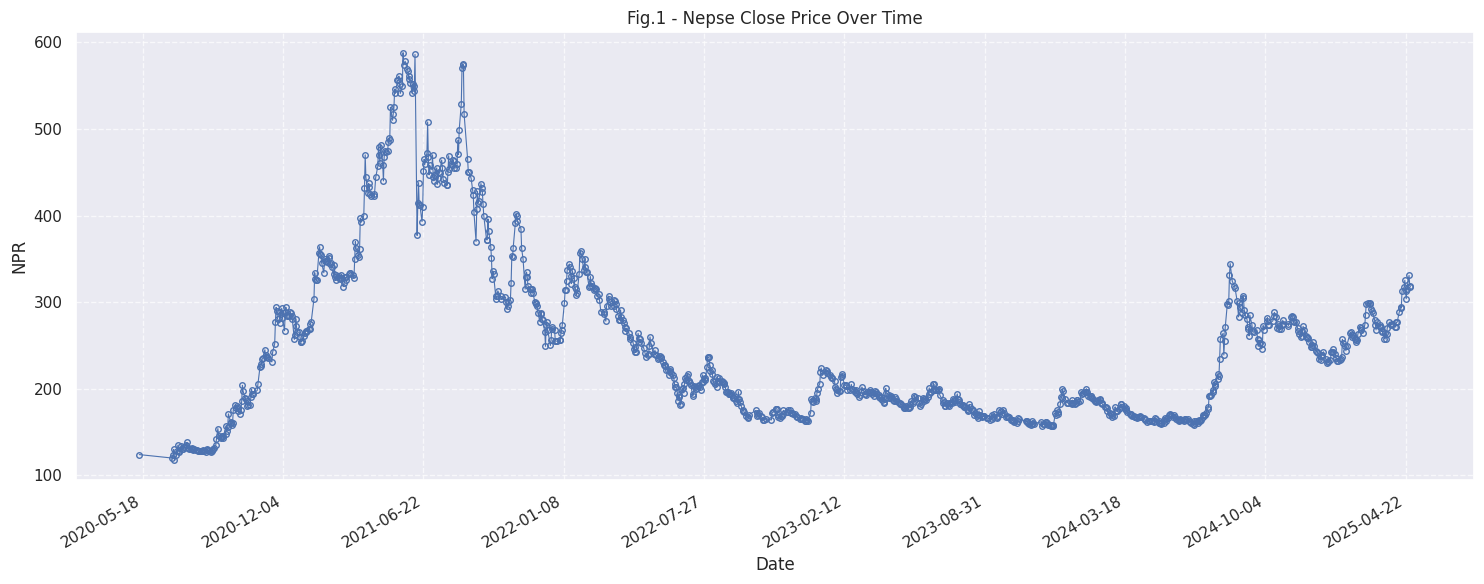

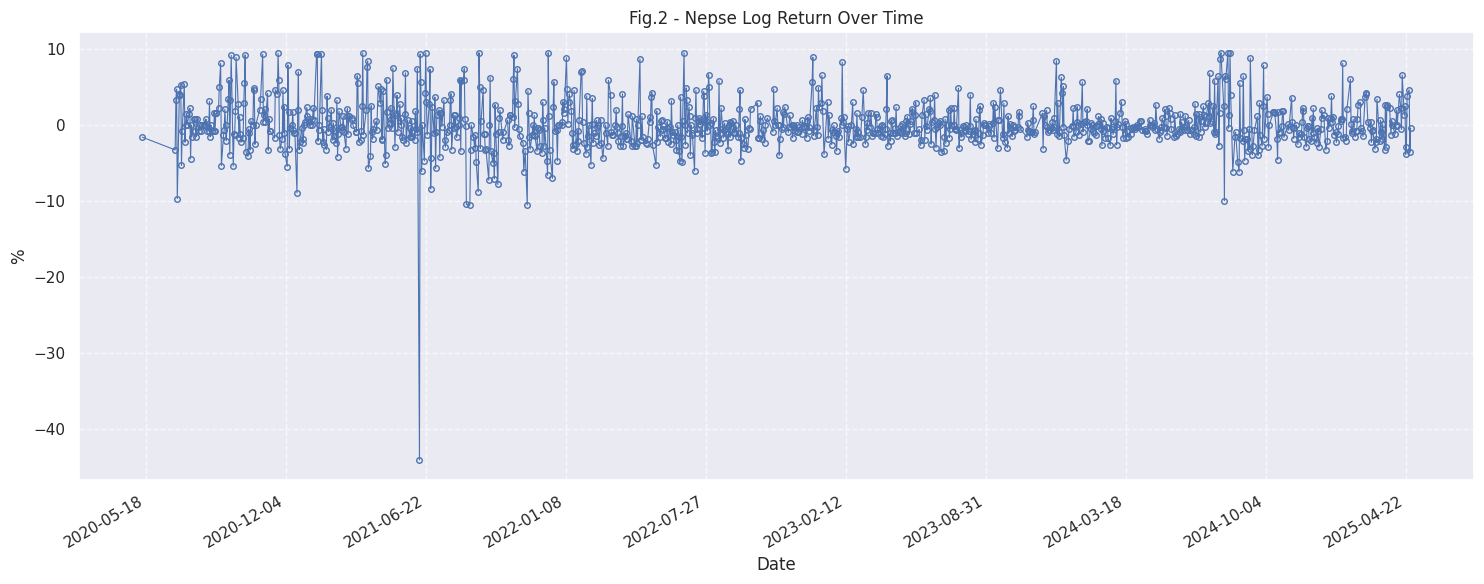

In [5]:
plot_single_plot(df['Close'], 'NPR', 'Fig.1 - Nepse Close Price Over Time')
plot_single_plot(df['Log_Return'], '%', 'Fig.2 - Nepse Log Return Over Time')

Fig.3 - Histogram & QQ Plot


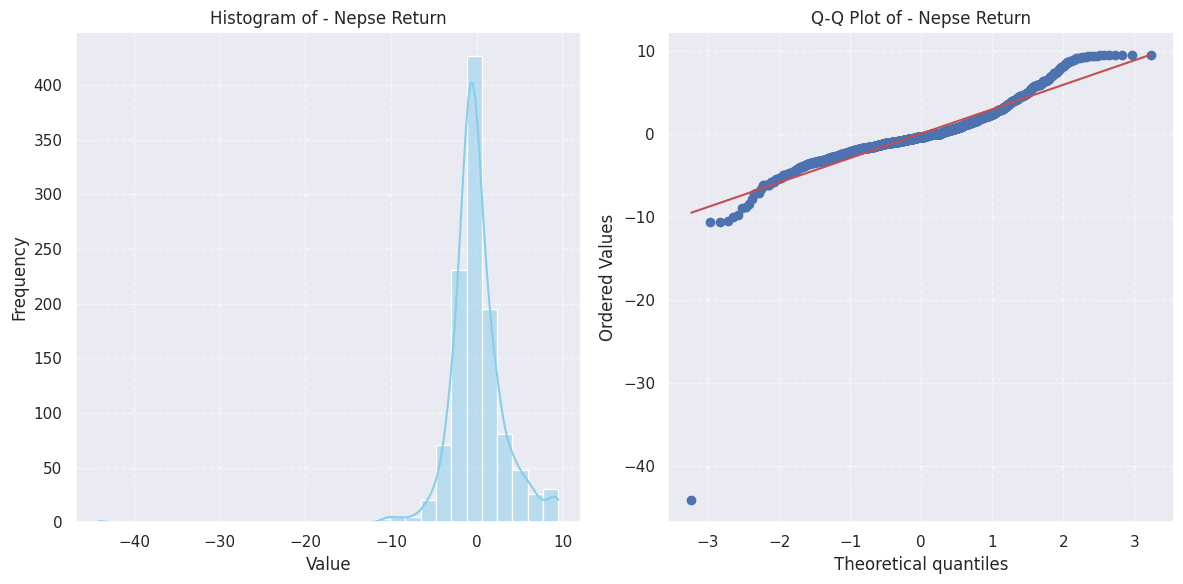

In [6]:
print('Fig.3 - Histogram & QQ Plot')
plot_histogram_qq(df['Log_Return'], title_prefix=' - Nepse Return')

In [7]:
# Calculate statistics
desc_stats = df['Log_Return'].describe()
skew_val = skew(df['Log_Return'])
kurtosis_val = kurtosis(df['Log_Return'])  # This will now work

# Create a table-friendly list
stats_table = [
    ["Count", desc_stats['count']],
    ["Mean", desc_stats['mean']],
    ["Std", desc_stats['std']],
    ["Min", desc_stats['min']],
    ["25%", desc_stats['25%']],
    ["50%", desc_stats['50%']],
    ["75%", desc_stats['75%']],
    ["Max", desc_stats['max']],
    ["Skewness", skew_val],
    ["Kurtosis", kurtosis_val]
]

# Display the table
print(tabulate(stats_table,
               headers=["Statistic", "Value"],
               tablefmt='fancy_grid',
               stralign='center',
               numalign='center',
               floatfmt=".4f"))

╒═════════════╤═══════════╕
│  Statistic  │   Value   │
╞═════════════╪═══════════╡
│    Count    │ 1143.0000 │
├─────────────┼───────────┤
│    Mean     │  0.0809   │
├─────────────┼───────────┤
│     Std     │  3.2003   │
├─────────────┼───────────┤
│     Min     │ -44.1075  │
├─────────────┼───────────┤
│     25%     │  -1.4813  │
├─────────────┼───────────┤
│     50%     │  -0.3046  │
├─────────────┼───────────┤
│     75%     │  1.3213   │
├─────────────┼───────────┤
│     Max     │  9.5310   │
├─────────────┼───────────┤
│  Skewness   │  -1.7848  │
├─────────────┼───────────┤
│  Kurtosis   │  32.3379  │
╘═════════════╧═══════════╛


- **Count**: 1,143 observations — a substantial sample size for analysis.
- **Mean**: 0.0809 — the average log return is slightly positive.
- **Standard Deviation**: 3.20 — indicates relatively high volatility in returns.
- **Min & Max**: The values range from **-44.11** to **9.53**, showing the presence of **extreme negative outliers**.
- **Median (50%)**: -0.30 — the median is negative, suggesting more frequent small losses than gains.
- **Skewness**: -1.78 — indicates a **left-skewed distribution**, meaning **extreme negative returns** occur more often than extreme positive ones.
- **Kurtosis**: 32.34 — this is very high (normal distribution has kurtosis ≈ 3), suggesting the distribution has **heavy tails** (i.e., more extreme outliers than a normal distribution).


In [9]:
# Apply Winsorization: cap bottom and top 1% values
winsorized = winsorize(df['Log_Return'], limits=[0.01, 0.01])

# Store in DataFrame for plotting
df['Winsorized'] = winsorized
df.head()

,Open,High,Low,Close,Volume,Return,Log_Return,Winsorized
Date,,,,,,,,
2020-05-13,124.0,124.0,124.0,124.00,20.0,-1.587302,-1.600034,-1.600034
2020-06-29,122.0,122.0,116.0,120.00,9570.0,-3.225806,-3.278982,-3.278982
2020-06-30,121.0,124.0,121.0,124.00,852.0,3.333333,3.278982,3.278982
2020-07-01,126.0,132.0,126.0,130.00,2903.0,4.838710,4.725288,4.725288
2020-07-02,132.0,134.0,118.0,118.00,2583.0,-9.230769,-9.684983,-7.082605
...,...,...,...,...,...,...,...,...
2025-04-23,312.0,312.9,300.0,303.88,1044422.0,-2.873398,-2.915488,-2.915488
2025-04-24,300.2,320.0,295.0,315.74,919186.0,3.902856,3.828620,3.828620
2025-04-27,315.0,335.0,315.0,330.80,1604962.0,4.769747,4.659487,4.659487


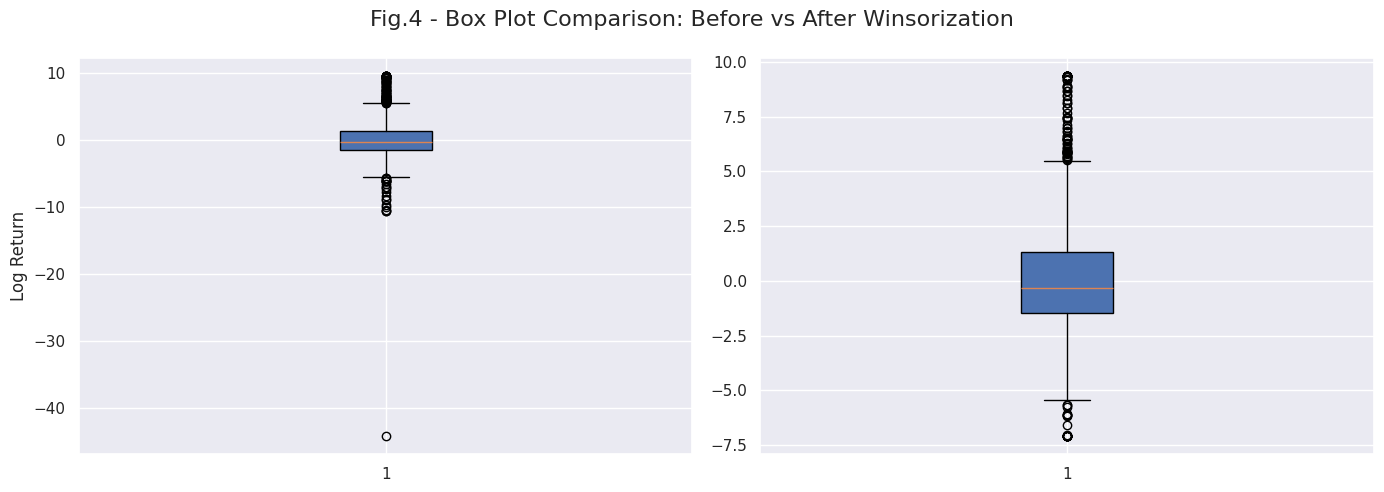

In [17]:
# Plot box plots before and after
plt.figure(figsize=(14, 5))

# Before Winsorization
plt.subplot(1, 2, 1)
plt.boxplot(df['Log_Return'].dropna(), vert=True, patch_artist=True)
plt.ylabel("Log Return")

# After Winsorization
plt.subplot(1, 2, 2)
plt.boxplot(df['Winsorized'].dropna(), vert=True, patch_artist=True)

# Add a single title for the entire figure
plt.suptitle("Fig.4 - Box Plot Comparison: Before vs After Winsorization", fontsize=16)

plt.tight_layout()
plt.show()

In our case, the kurtosis of the data is so high, which may affect the ARIMA model. Winsorization can help by making the data more stable, improving model accuracy and forecasting performance by ensuring that extreme fluctuations don’t disproportionately influence the results.

## 3. Stationarity Testing

- ADF Statistic < Critical Value → Reject the null hypothesis → the series is stationary.

- p-value < 0.05 → Strong evidence against the null → the series is stationary

In [12]:
# Perform the ADF test without Trend and Drift
adf(df['Winsorized'], trend='n', method='aic')

Augmented Dickey-Fuller Unit Root Test:



Test Statistic,-18.662
P-value,0.000
Lags,2


In [13]:
# Perform the ADF test With Drift (Constant but no trend)
adf(df['Winsorized'], trend='c', method='aic')  # Constant only

Augmented Dickey-Fuller Unit Root Test:



Test Statistic,-18.731
P-value,0.000
Lags,2


In [14]:
# Perform the ADF test With Trend and Drift
adf(df['Winsorized'], trend='ct', method='aic')

Augmented Dickey-Fuller Unit Root Test:



Test Statistic,-18.763
P-value,0.000
Lags,2


## 4. ARIMA Model Building

### A. Plot ACF and PACF to identify AR and MA terms

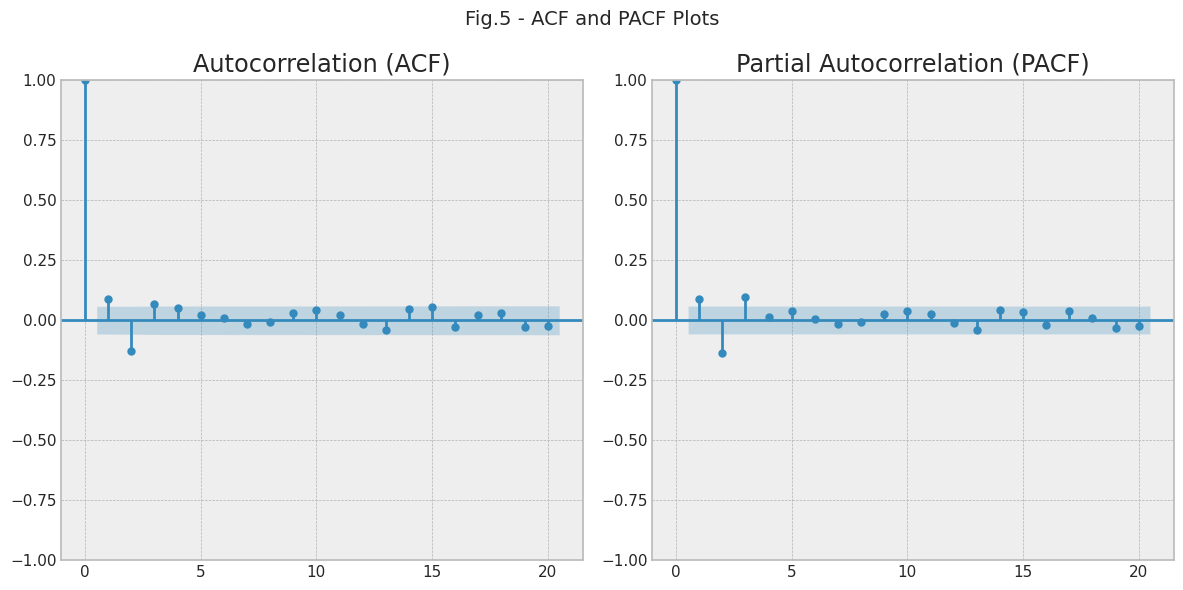

In [18]:
acf_plot(df['Winsorized'], lags=20, figsize=(12, 6), style='bmh', title='Fig.5 - ACF and PACF Plots')

### B. Fit several ARIMA(p,d,q) models

In [19]:
# Fit the auto_arima model
model_auto_selection = auto_arima(
    df['Winsorized'],
    start_p = 0,
    start_q = 0,
    max_p = 5,
    max_q = 5,
    information_criterion='aic',
    trace=True,
    with_intercept=False,
    return_valid_fits=True,
)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5655.913, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=5648.200, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5644.393, Time=0.20 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=5627.005, Time=0.58 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=5622.483, Time=0.53 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=5628.882, Time=0.31 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=5620.768, Time=1.30 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=5619.717, Time=0.15 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=5621.370, Time=0.32 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=5620.532, Time=2.17 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=5619.537, Time=0.27 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=5628.233, Time=0.24 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=5621.257, Time=0.68 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=5620.789, Time=2.37 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept

### C. Choose the best model

In [20]:
# Fit the model with the optimal lag based on auto_arima
model_arima = ARIMA(df['Winsorized'], order=(3, 0, 0), trend='n').fit()
model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Winsorized   No. Observations:                 1143
Model:                 ARIMA(3, 0, 0)   Log Likelihood               -2805.858
Date:                Thu, 01 May 2025   AIC                           5619.717
Time:                        06:58:15   BIC                           5639.883
Sample:                    05-13-2020   HQIC                          5627.331
                         - 04-29-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1178      0.022      5.385      0.000       0.075       0.161
ar.L2         -0.1466      0.026     -5.642      0.000      -0.197      -0.096
ar.L3          0.0988      0.025      4.013      0.000       0.051       0.147
sigma2         7.9384      0.244     32.522      0.000       7.460       8.417
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               238.06
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.48   Skew:                             0.77
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
# Fit the model based on ACF and PACF
model_arima_2 = ARIMA(df['Winsorized'], order=(3, 0, 4), trend='n').fit()
model_arima_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Winsorized   No. Observations:                 1143
Model:                 ARIMA(3, 0, 4)   Log Likelihood               -2802.792
Date:                Thu, 01 May 2025   AIC                           5621.583
Time:                        06:58:35   BIC                           5661.914
Sample:                    05-13-2020   HQIC                          5636.812
                         - 04-29-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6301      0.247      2.553      0.011       0.146       1.114
ar.L2         -0.6864      0.202     -3.401      0.001      -1.082      -0.291
ar.L3         -0.2361      0.214     -1.104      0.269      -0.655       0.183
ma.L1         -0.5155      0.246     -2.098      0.036      -0.997      -0.034
ma.L2          0.4843      0.164      2.950      0.003       0.162       0.806
ma.L3          0.4545      0.169      2.687      0.007       0.123       0.786
ma.L4         -0.0666      0.056     -1.197      0.231      -0.176       0.042
sigma2         7.8995      0.247     31.984      0.000       7.415       8.384
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               218.16
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.48   Skew:                             0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Based on low AIC and BIC, the next section proceeds with model_arima.

## 5. Forecasting HIDCL Returns

### A. Expanding Window Forecast

In [42]:
# Define initial training size (e.g., 70% of the data)
train_size = int(len(df['Winsorized']) * 0.8)
train, test = df['Winsorized'][:train_size], df['Winsorized'][train_size:]

# Store forecasts
forecast_list = []

# Expanding window forecast loop
for i in range(len(test)):
    train_expanding = df['Winsorized'][:train_size + i]
    model = ARIMA(train_expanding, order=(3, 0, 0), trend='n').fit()
    forecast = model.forecast(steps=1)
    forecast_list.append(forecast[0])

# Convert forecast to Series aligned with test set
forecast_series = pd.Series(forecast_list, index=test.index)

# Evaluate the performance
mae = mean_absolute_error(test, forecast_series)
mse = mean_squared_error(test, forecast_series)
r2 = r2_score(test, forecast_series)

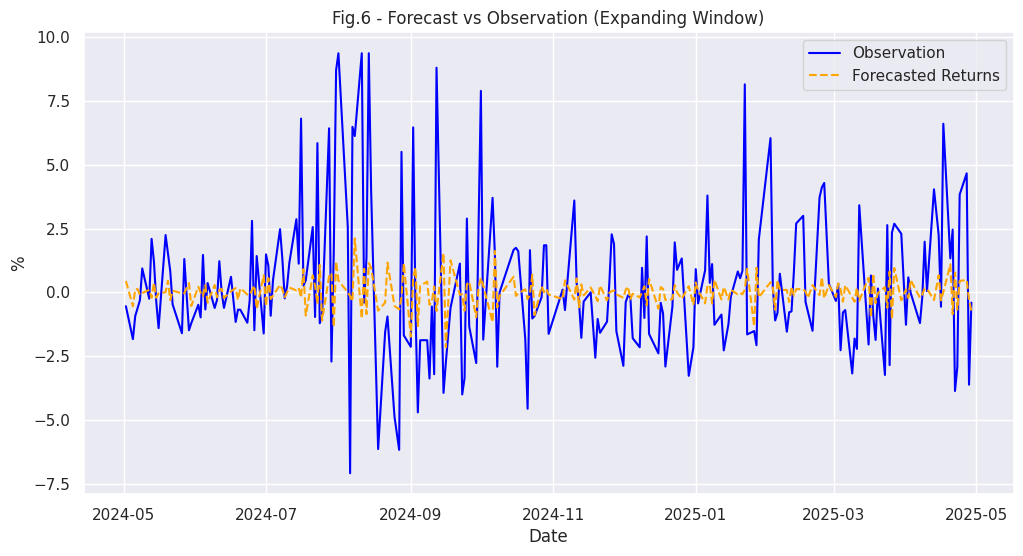

In [73]:
# Convert PeriodIndex to DatetimeIndex
test_plot = test.copy()
forecast_plot = forecast_series.copy()

test_plot.index = test_plot.index.to_timestamp()
forecast_plot.index = forecast_plot.index.to_timestamp()

# Plot forecast vs actual
plt.figure(figsize=(12, 6))
plt.plot(test_plot, label='Observation', color='blue')
plt.plot(forecast_plot, label='Forecasted Returns', color='orange', linestyle='--')
plt.title('Fig.6 - Forecast vs Observation (Expanding Window)')
plt.xlabel('Date')
plt.ylabel('%')
plt.legend()
plt.grid(True)
plt.show()

### B. Fixed Rolling Window Forecast

In [76]:
# Ensure 'Log_Return' has no missing values
returns = df['Winsorized'].dropna()

# Define the size of the rolling window (e.g., 100 observations)
window_size = 100

# Split the data into training and test sets
train_2 = returns[:window_size]
test_2 = returns[window_size:]

# Initialize a list to store forecasts
forecast_list_2 = []

# Perform rolling window forecasting
for i in range(len(test_2)):
    train_window = returns[i : i + window_size]
    model = ARIMA(train_window, order=(3, 0, 0), trend='n')
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=1)
    forecast_list_2.append(forecast[0])

# Create a forecast series aligned with the test set
forecast_series_2 = pd.Series(forecast_list_2, index=test_2.index)

# Evaluate the performance
mae_2 = mean_absolute_error(test_2, forecast_series_2)
mse_2 = mean_squared_error(test_2, forecast_series_2)
r2_2 = r2_score(test_2, forecast_series_2)

# Create table with tabulate
headers = ['Model', 'MSE', 'MAE', 'R2']
data = [['Expanding Window', mse, mae, r2],
        ['Fixed Rolling Window', mse_2, mae_2, r2_2]]

print(tabulate(data, headers=headers, tablefmt='fancy_grid', stralign='center', numalign='center', floatfmt=".2f"))

╒══════════════════════╤═══════╤═══════╤═══════╕
│        Model         │  MSE  │  MAE  │  R2   │
╞══════════════════════╪═══════╪═══════╪═══════╡
│   Expanding Window   │ 7.70  │ 2.02  │ 0.01  │
├──────────────────────┼───────┼───────┼───────┤
│ Fixed Rolling Window │ 8.00  │ 1.99  │ -0.02 │
╘══════════════════════╧═══════╧═══════╧═══════╛


- The Expanding Window method appears to be the better approach for this dataset, as it provides lower errors and a slightly positive R².

- Both models have limited predictive power (with low R² values), suggesting that the ARMA(3,0,0) model might not be ideal for capturing the dynamics of this data.



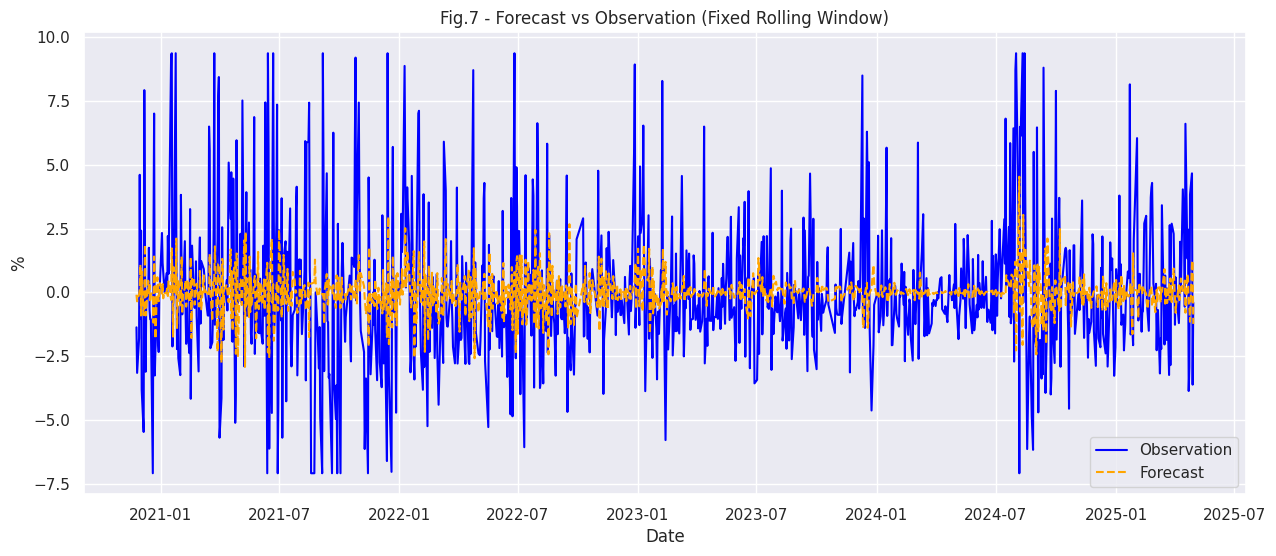

In [79]:
# Convert PeriodIndex to DatetimeIndex
test_plot_2 = test_2.copy()
forecast_plot_2 = forecast_series_2.copy()

test_plot_2.index = test_plot_2.index.to_timestamp()
forecast_plot_2.index = forecast_plot_2.index.to_timestamp()

# Plot forecast vs actual
plt.figure(figsize=(15, 6))
plt.plot(test_plot_2, label='Observation', color='blue')
plt.plot(forecast_plot_2, label='Forecast', color='orange', linestyle='--')
plt.title('Fig.7 - Forecast vs Observation (Fixed Rolling Window)')
plt.xlabel('Date')
plt.ylabel('%')
plt.legend()
plt.grid(True)
plt.show()

## 6. Model Diagnostics & Residual Analysis

Fig.9 - ARIMA(3,0,0) Model Diagnostics:



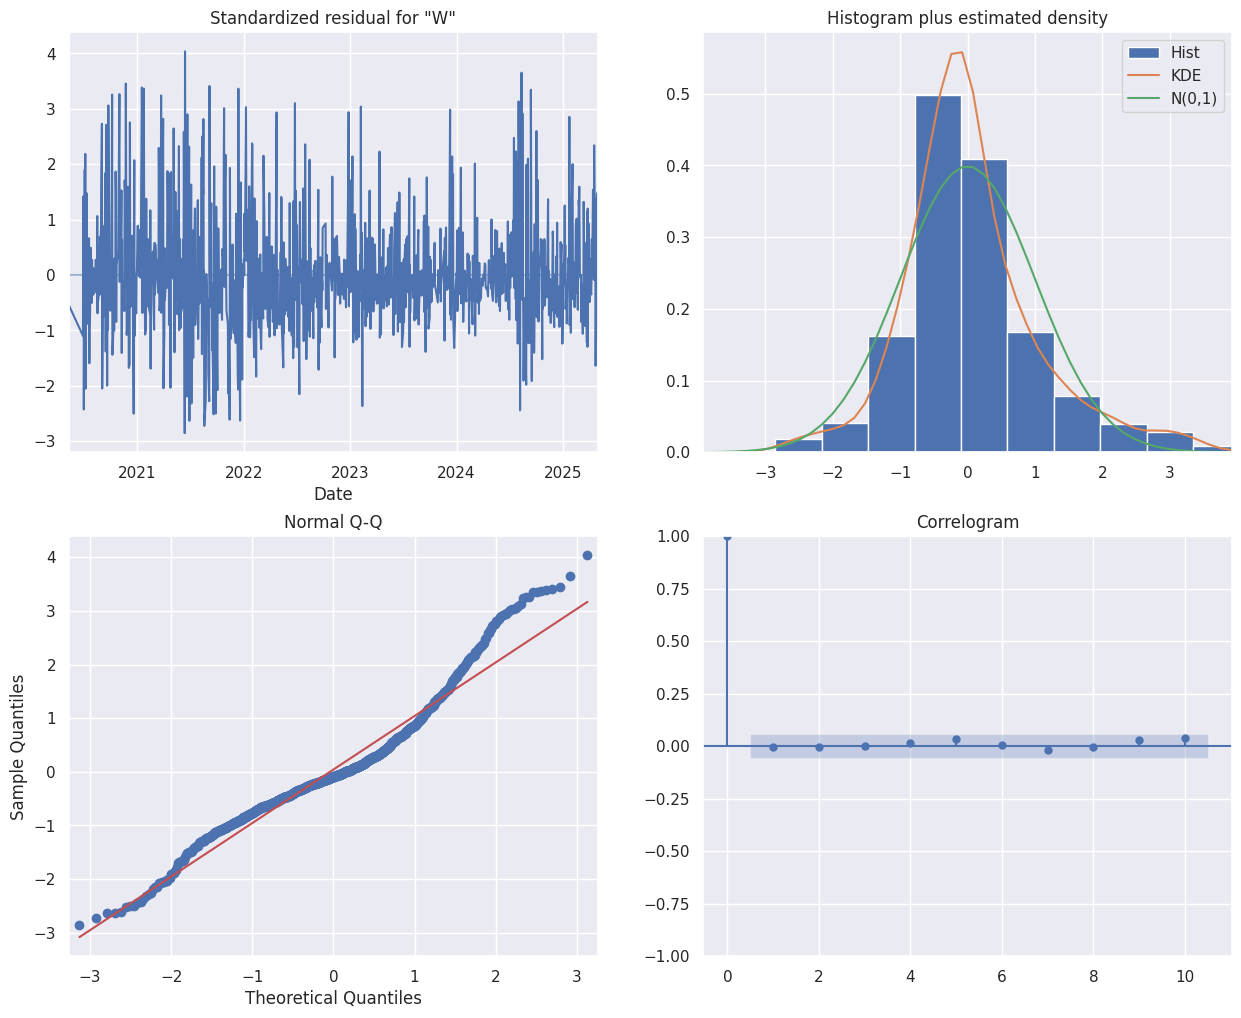

In [80]:
print('Fig.9 - ARIMA(3,0,0) Model Diagnostics:\n')
model_arima.plot_diagnostics(figsize=(15,12))
plt.show()

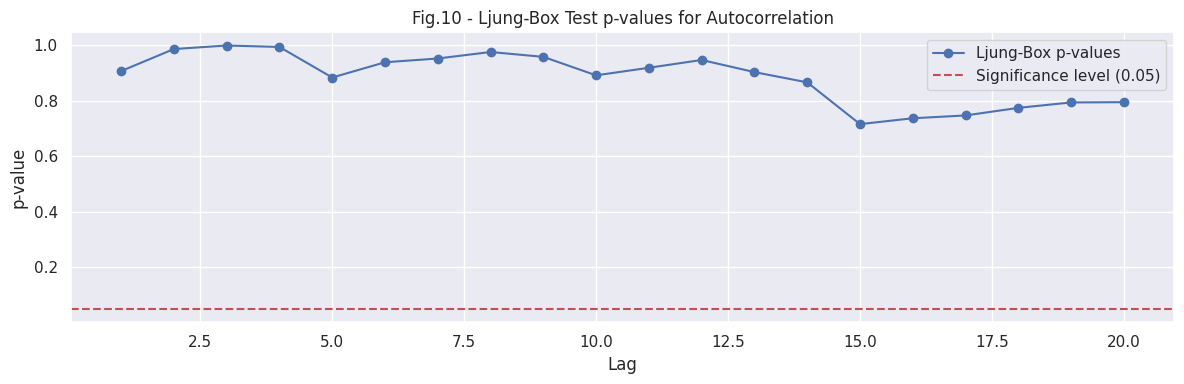

In [81]:
# Ljung-Box test
lb_test = sm.stats.diagnostic.acorr_ljungbox(model_arima.resid, lags=20, return_df=True)

# Plot p-values with reference line at alpha = 0.05
plt.figure(figsize=(12, 4))
plt.plot(lb_test.index, lb_test['lb_pvalue'], marker='o', label='Ljung-Box p-values')
plt.axhline(y=0.05, color='r', linestyle='--', label='Significance level (0.05)')

# Labeling
plt.title('Fig.10 - Ljung-Box Test p-values for Autocorrelation')
plt.xlabel('Lag')
plt.ylabel('p-value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The Ljung-Box test indicates no significant autocorrelation, which is good, but the non-constant variance and non-normal residuals suggest that the model may not be fully capturing the underlying data structure.



## 7. Strategy based on ARIMA

In [83]:
def generate_signals(df, column, target='long_only'):
    # Create a copy of the original DataFrame
    df_copy = df.copy()

    # Initialize the 'Strategy' column in the copy
    df_copy['Strategy'] = 0

    # Shift predictions to compare t+1 with t
    price_t = df_copy[column]
    price_t1 = df_copy[column].shift(-1)  # Shift by 1 to compare t+1 prices

    if target == 'long_only':
        # Long position (1) when price_t1 > price_t, otherwise no position (0)
        df_copy['Strategy'] = np.where(price_t1 > price_t, 1, 0)

    elif target == 'long_short':
        # Long position (1) when price_t1 > price_t, Short position (-1) when price_t1 < price_t
        df_copy['Strategy'] = np.where(price_t1 > price_t, 1, -1)

    # Return the DataFrame with strategies applied
    return df_copy

def plot_strategy_signals(df,title='Test Prediction with Strategy Signals'):
    """
    Plots Test_Prediction values and overlays Long Only Strategy signals.

    Parameters:
    df (pd.DataFrame): DataFrame with 'Observation' and 'Strategy' columns.
                       The index should be of type datetime.

    Returns:
    None
    """
    plt.figure(figsize=(14, 7))

    # Convert PeriodIndex to DatetimeIndex if necessary
    if isinstance(df.index, pd.PeriodIndex):
        df.index = df.index.to_timestamp()

    # Plot the real close price
    plt.plot(df.index, df['Observation'], label='Real Close Price', color='blue')

    # Plot strategy signals
    long_signals = df[df['Strategy'] == 1.0]
    hold_signals = df[df['Strategy'] == 0.0]

    plt.scatter(long_signals.index, long_signals['Observation'], marker='^', color='green', label='Long Signal', alpha=1)
    plt.scatter(hold_signals.index, hold_signals['Observation'], marker='o', color='red', label='No Signal', alpha=0.5)

    # Formatting
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Test Prediction')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Save and show
    plt.savefig('strategy.png', dpi=300)
    plt.show()

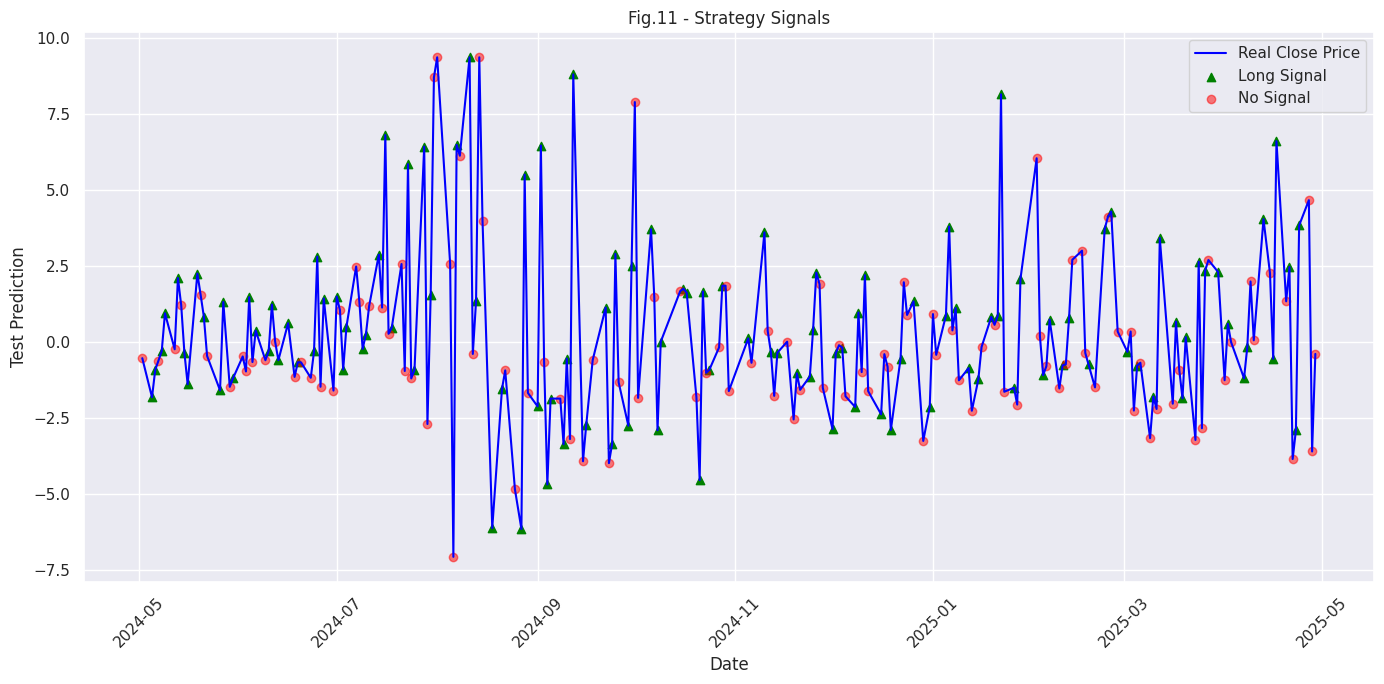

In [85]:
# Long Only
#forecast_series = forecast_series.to_frame(name='Forecast')
long_only_signal = generate_signals(forecast_series,'Forecast',target='long_only')
long_only_signal['Observation'] = test
plot_strategy_signals(long_only_signal,'Fig.11 - Strategy Signals')

Based on Fig.11, it can be said that signals generated by ARIMA don't fully capture the return movement.